### Simple Linear Model

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

In [5]:
tf.__version__

'0.8.0'

##### Part I. 探索数据集

In [1]:
# The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.
# 手动从 http://yann.lecun.com/exdb/mnist/ 下载到容器 /notebooks/data/MNIST/ 目录下
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)    # 把 images 和 labels 都导入为 one-hot vectors
data[0]

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [2]:
print("TrainingSet: {}".format(len(data.train.labels)))
print("TestSet: {}".format(len(data.test.labels)))
print("ValidationSet: {}".format(len(data.validation.labels)))

TrainingSet: 55000
TestSet: 10000
ValidationSet: 5000


In [4]:
data.test.labels[0:5, :]    # 可以看到，待预测 label 是 10 维的，就是说 10 个分类：0 ~ 9

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [8]:
# 看看具体是 0 ~ 9 中的哪一个
data.test.cls = np.array([l.argmax() for l in data.test.labels])
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

In [15]:
data.train.images.shape      # 看到 images 也是 one-hot vector，784 = 28 * 28

(55000, 784)

In [16]:
img_size = 28
img_size_flat = img_size * img_size # 784
img_shape = (img_size, img_size)
num_classes = 10

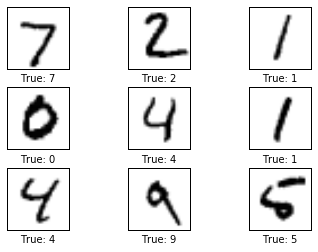

In [20]:
# 绘制辅助函数
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9  # 绘制 9 个图像
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        # 显示标签
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])   # 不显示刻度
        ax.set_yticks([])

images = data.test.images[0:9]
cls_true = data.test.cls[0:9]   # data.test.labels 是 one-hot 的，data.test.cls 是上面转成1维的结果
plot_images(images=images, cls_true=cls_true)

##### Part II. Tensorflow Graph Design

In [21]:
# 定义常量
x = tf.placeholder(tf.float32, [None, img_size_flat])  # None 表示 x 可以表示任意多个 images；images 数据的维度为 img_size_flat
y_true = tf.placeholder(tf.float32, [None, num_classes]) # 类似上面，y_true 每个标签维度为 num_classes(10)，也即 one-hot 
y_true_cls = tf.placeholder(tf.int64, [None])  # 任意多个 int64 scalar，也就是 1 维标签结果

In [23]:
# 定义变量
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))   # 784 * 10 维矩阵，初始化为 0
biases = tf.Variable(tf.zeros([num_classes]))   # 10 维矢量，初始化为 0

In [26]:
# 选择 softmax 为输出层
logits = tf.matmul(x, weights) + biases    # (N * 784 矩阵) * (784 * 10 矩阵) + (10 矢量) ===> (N * 10 矩阵) 
y_pred = tf.nn.softmax(logits)    # softmax 为输出，得到 N * 10 维结果
y_pred_cls = tf.argmax(y_pred, dimension=1)    # 取最大的标签 index 为 N * 1 维结果; argmax 在第二个维度上进行，即保持 N 不变，每个 N 中的元素进行 argmax

In [27]:
# 选择 交叉熵 为 lost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)  # softmax_cross_entropy_with_logits also calculates the softmax internally.
cost = tf.reduce_mean(cross_entropy)  # 转化为 1 维，以便比较 lost (cost)，故此取平均值

In [28]:
# 选择 Gradient Descent 为优化函数
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [29]:
# Performance Measures 选择正确分类的比例，即正确分类 / 总数
correct_prediction = tf.equal(y_pred_cls, y_true_cls)  # 每个元素是一个 Bool 值,表示是否 match
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))  # Bool 转为 float 然后取平均值

##### Part III. Tensorflow Run